# Junction Naming

__December 2022__

Can we find an automatic way of naming junctions?

In [1]:
import sys
import importlib
import osmnx as ox

sys.path.append("../src/")
f = importlib.import_module('03-build-junctions-graph')

# this prevents a lot of future warnings that are coming out of oxmnx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Dan/Documents/Projects/Volunteering/lcc-dangerous-junctions/venv/lib/python3.9/site-packages/osmnx/graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


Nodes: 127599


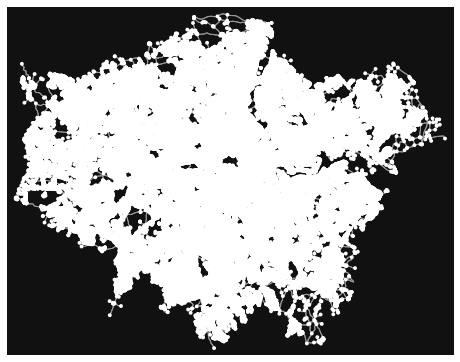

In [48]:
G1 = ox.graph_from_place(
    'London, UK',
    network_type='drive',
    simplify=True,
    clean_periphery=True
)

print(f'Nodes: {len(G1.nodes)}')
ox.plot_graph(G1);

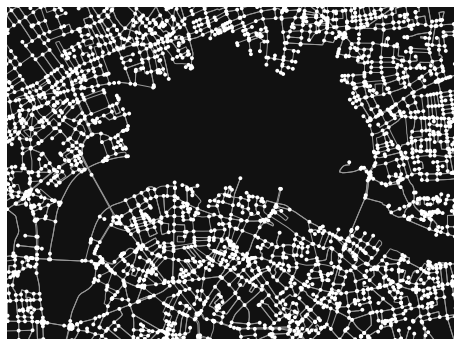

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [49]:
ox.plot_graph(G1, bbox=(51.525727, 51.493141, -0.060425, -0.130806))

Nodes: 47070


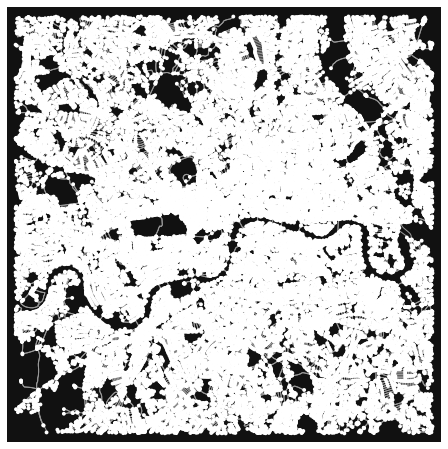

In [50]:
G1 = ox.graph_from_address(
    'London, UK',
    network_type='drive',
    dist=10000
)

print(f'Nodes: {len(G1.nodes)}')
ox.plot_graph(G1);

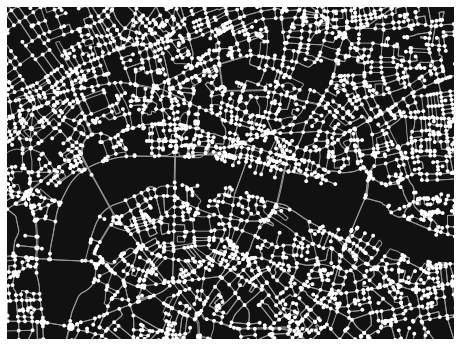

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [51]:
ox.plot_graph(G1, bbox=(51.525727, 51.493141, -0.060425, -0.130806))

Nodes: 334


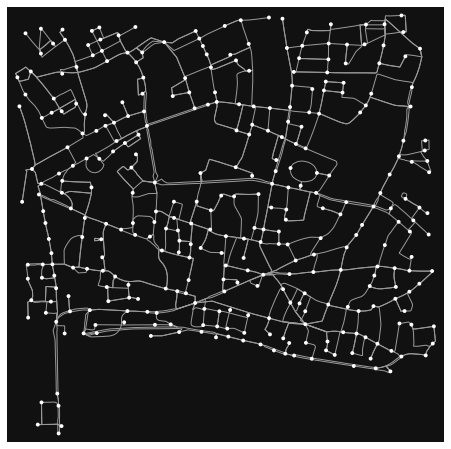

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [36]:
G2 = ox.consolidate_intersections(
    ox.project_graph(G1),
    tolerance=20,  # combines junctions within 40m
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True
)

print(f'Nodes: {len(G2.nodes)}')
ox.plot_graph(G2)

In [4]:
def combine_names(names):
    if type(names) == str:
        return [names]
    
    flat_names = []
    for n in names:
        if type(n) == list:
            for m in n:
                flat_names.append(m)
        else:
            flat_names.append(n)
    
    unique_names = list(set(flat_names))

    return unique_names


def list_to_string_name(names):
    names = [name for name in names if (name != '') & (name == name)]
        
    name = '-'.join(names)
    if name == '':
        name = 'Unknown'
    return name


def convert_strings_list(x):
    '''
    Function to convert a list stored in a string to a list.
    '''
    if type(x) == int:
        return [x]
    else:
        return x.strip('][').split(', ')

In [26]:
# create datafraems from G1 & G2
df_lower = (
    ox.graph_to_gdfs(
        G1,
        nodes=True,
        edges=False,
        node_geometry=True,
        fill_edge_geometry=False
    )
    .drop(columns=['highway', 'street_count'])
    .reset_index()
    .rename(columns={'y': 'lat', 'x': 'lon', 'osmid': 'osmid_original'})
)

df_higher = ox.graph_to_gdfs(
    G2,
    nodes=True,
    edges=False,
    node_geometry=True,
    fill_edge_geometry=False
)

df_higher['osmid_original'] = df_higher['osmid_original'].apply(convert_strings_list)
df_higher = df_higher.explode('osmid_original')
df_higher['osmid_original'] = df_higher['osmid_original'].astype(int)

df_higher = (
    df_higher
    .reset_index()
    .drop(columns=['x', 'y', 'street_count', 'highway', 'lon', 'lat'])
    .rename(columns={'osmid': 'osmid_cluster'})
)

# Combine datasets
df = df_lower.merge(
    df_higher,
    how='inner',
    on='osmid_original',
    suffixes=['_original', '_cluster']
)

# calculate lat, lons for clusters
cluster_coords = (
    df
    .groupby('osmid_cluster')[['lat', 'lon']]
    .mean()
    .reset_index()
    .rename(columns={'lat': 'latitude_cluster', 'lon': 'longitude_cluster'})
)

# join in
df = df.merge(
    cluster_coords,
    how='left',
    on='osmid_cluster'
)

# fill nulls with the lower level coordinate when missing
df['latitude_cluster'] = df['latitude_cluster'].fillna(df['lat'])
df['longitude_cluster'] = df['longitude_cluster'].fillna(df['lon'])

# drop some cols and rename some
df = (
    df
    .drop(
        columns=['geometry_original', 'geometry_cluster']
    )
    .reset_index()
    .rename(
        columns={
            'index': 'junction_index',
            'lat': 'latitude_junction',
            'lon': 'longitude_junction',
            'osmid_original': 'junction_id',
            'osmid_cluster': 'junction_cluster_id'
        }
    )
)

df.head()

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster
0,0,107322,51.516246,-0.132866,0,51.516246,-0.132866
1,1,107324,51.515647,-0.132440,2,51.515647,-0.132440
2,2,107326,51.515137,-0.132766,4,51.515137,-0.132766
3,3,107328,51.514820,-0.132309,5,51.514820,-0.132309
4,4,107333,51.515305,-0.141966,7,51.515268,-0.142009


In [27]:
junction_names = (
    ox
    .graph_to_gdfs(G1, nodes=False)
    .reset_index()
    [['u', 'name']]
    .fillna('')
)

junction_names['name'] = junction_names['name'].apply(combine_names)

df = df.merge(
    junction_names,
    how='left',
    left_on='junction_id',
    right_on='u'
)

cluster_names = df.groupby('junction_cluster_id')['name'].apply(combine_names).reset_index()

df = df.merge(
    cluster_names,
    how='left',
    on='junction_cluster_id',
    suffixes=['', '_cluster']
)

df.head()

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster,u,name,name_cluster
0,0,107322,51.516246,-0.132866,0,51.516246,-0.132866,107322.0,[Oxford Street],[Oxford Street]
1,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,107324.0,[Soho Square],"[Soho Square, Soho Street]"
2,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,107324.0,[Soho Street],"[Soho Square, Soho Street]"
3,2,107326,51.515137,-0.132766,4,51.515137,-0.132766,107326.0,[Soho Square],[Soho Square]
4,3,107328,51.514820,-0.132309,5,51.514820,-0.132309,107328.0,[Frith Street],"[Soho Square, Frith Street]"


In [29]:
df['junction_cluster_name'] = df['name_cluster'].apply(list_to_string_name)

df['name_rank'] = (
    df
    .groupby(['junction_cluster_name'])['junction_cluster_id']
    .transform('rank', method='dense')
)

df['name_max_rank'] = (
    df
    .groupby(['junction_cluster_name'])['name_rank']
    .transform('max')
)

df['junction_cluster_name_plus_rank'] = (
    df['junction_cluster_name'] + '-' + df['name_rank'].astype(int).astype(str)
)

(
    df
    .groupby('junction_cluster_name_plus_rank')
    ['junction_cluster_id']
    .nunique()
    .reset_index()
    .sort_values(by='junction_cluster_id')
)

df

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster,u,name,name_cluster,junction_cluster_name,name_rank,name_max_rank,junction_cluster_name_plus_rank
0,0,107322,51.516246,-0.132866,0,51.516246,-0.132866,1.073220e+05,[Oxford Street],[Oxford Street],Oxford Street,1.0,5.0,Oxford Street-1
1,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,1.073240e+05,[Soho Square],"[Soho Square, Soho Street]",Soho Square-Soho Street,1.0,1.0,Soho Square-Soho Street-1
2,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,1.073240e+05,[Soho Street],"[Soho Square, Soho Street]",Soho Square-Soho Street,1.0,1.0,Soho Square-Soho Street-1
3,2,107326,51.515137,-0.132766,4,51.515137,-0.132766,1.073260e+05,[Soho Square],[Soho Square],Soho Square,1.0,1.0,Soho Square-1
4,3,107328,51.514820,-0.132309,5,51.514820,-0.132309,1.073280e+05,[Frith Street],"[Soho Square, Frith Street]",Soho Square-Frith Street,1.0,1.0,Soho Square-Frith Street-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,563,9522532106,51.511867,-0.127111,43,51.511852,-0.127093,9.522532e+09,[Upper Saint Martin's Lane],"[Saint Martin's Lane, Long Acre, St. Martin's ...",Saint Martin's Lane-Long Acre-St. Martin's Lan...,1.0,1.0,Saint Martin's Lane-Long Acre-St. Martin's Lan...
1166,564,9576767098,51.516215,-0.120944,227,51.516208,-0.120934,9.576767e+09,[Parker Street],"[Newton Street, Parker Street]",Newton Street-Parker Street,1.0,1.0,Newton Street-Parker Street-1
1167,565,9650488591,51.498693,-0.117187,22,51.498871,-0.116904,9.650489e+09,[Lambeth Palace Road],"[Upper Marsh, Lambeth Palace Road, Royal Street]",Upper Marsh-Lambeth Palace Road-Royal Street,1.0,1.0,Upper Marsh-Lambeth Palace Road-Royal Street-1
1168,566,9778347750,51.500250,-0.116758,253,51.500619,-0.116260,9.778348e+09,[Lambeth Palace Road],"[, Station Approach, Lambeth Palace Road, York...",Station Approach-Lambeth Palace Road-York Road...,1.0,1.0,Station Approach-Lambeth Palace Road-York Road...


In [22]:
df[df['junction_cluster_name'] == 'Oxford Street'][
    ['junction_cluster_id', 'junction_cluster_name_plus_rank']
].drop_duplicates()

,junction_cluster_id,junction_cluster_name_plus_rank
0,0,Oxford Street-1
98,79,Oxford Street-3
213,154,Oxford Street-4
214,1,Oxford Street-2
691,246,Oxford Street-5


In [24]:
df.drop(columns=['name', 'u', 'name_rank', 'name_cluster'], inplace=True)
df = df.drop_duplicates()
    
df.head(20)

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster,junction_cluster_name,junction_cluster_name_plus_rank
0,0,107322,51.516246,-0.132866,0,51.516246,-0.132866,Oxford Street,Oxford Street-1
1,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,Soho Square-Soho Street,Soho Square-Soho Street-1
3,2,107326,51.515137,-0.132766,4,51.515137,-0.132766,Soho Square,Soho Square-1
4,3,107328,51.514820,-0.132309,5,51.514820,-0.132309,Soho Square-Frith Street,Soho Square-Frith Street-1
6,4,107333,51.515305,-0.141966,7,51.515268,-0.142009,Regent Street-Oxford Street,Regent Street-Oxford Street-1
8,5,107697,51.512774,-0.114520,9,51.512774,-0.114520,Strand-Arundel Street-Aldwych,Strand-Arundel Street-Aldwych-1
12,6,107698,51.511288,-0.113685,14,51.511288,-0.113685,Arundel Street,Arundel Street-1
13,7,107708,51.512914,-0.113761,12,51.513026,-0.113552,Strand,Strand-1
15,8,107715,51.510573,-0.121090,15,51.510609,-0.121091,Exeter Street-Savoy Court-Strand,Exeter Street-Savoy Court-Strand-1
17,9,107716,51.511077,-0.119718,17,51.511107,-0.119539,Savoy Street-Lancaster Place-Burleigh Street-S...,Savoy Street-Lancaster Place-Burleigh Street-S...
